In [1]:
import warnings
warnings.filterwarnings("ignore")

SEED = 1
N_IMG = 1

In [2]:
import random

import diffusers
from transformers import AutoModelForCausalLM, AutoTokenizer
import numpy as np
import torch

from src.diffusion_models import SDXLEditingPipeline
from src.llms import spot_objects
from src.detectors import OWLViTv2Detector

device = torch.device("cuda:1")
device1 = torch.device("cuda:2")
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

In [3]:
base = SDXLEditingPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0",  use_safetensors=True, torch_dtype=torch.float16, variant="fp16", use_onnx=False
)
base.to(device1)
use_ddpm = True
if use_ddpm:
  print('Using DDPM as scheduler.')
  base.scheduler = diffusers.DDPMScheduler.from_config(base.scheduler.config)

Loading pipeline components...: 100%|██████████| 7/7 [00:01<00:00,  5.55it/s]


Using DDPM as scheduler.


In [4]:
prompts = [
    "Two people enjoying hot dogs and soda pop.",
    "Two people walking under an umbrella on a street near some benches and a motorcycle.",
    "a woman in a blue top carrying two surfboards across a street",
    "A woman surfer riding on a crashing wave",
    "A man walking along a beach holding a surfboard"
]

In [5]:
generator = torch.Generator(device=device1).manual_seed(SEED)
out = base(prompt=[prompts[0]]*N_IMG, num_inference_steps=300, generator=generator, latents=None)

100%|██████████| 300/300 [00:37<00:00,  7.93it/s]


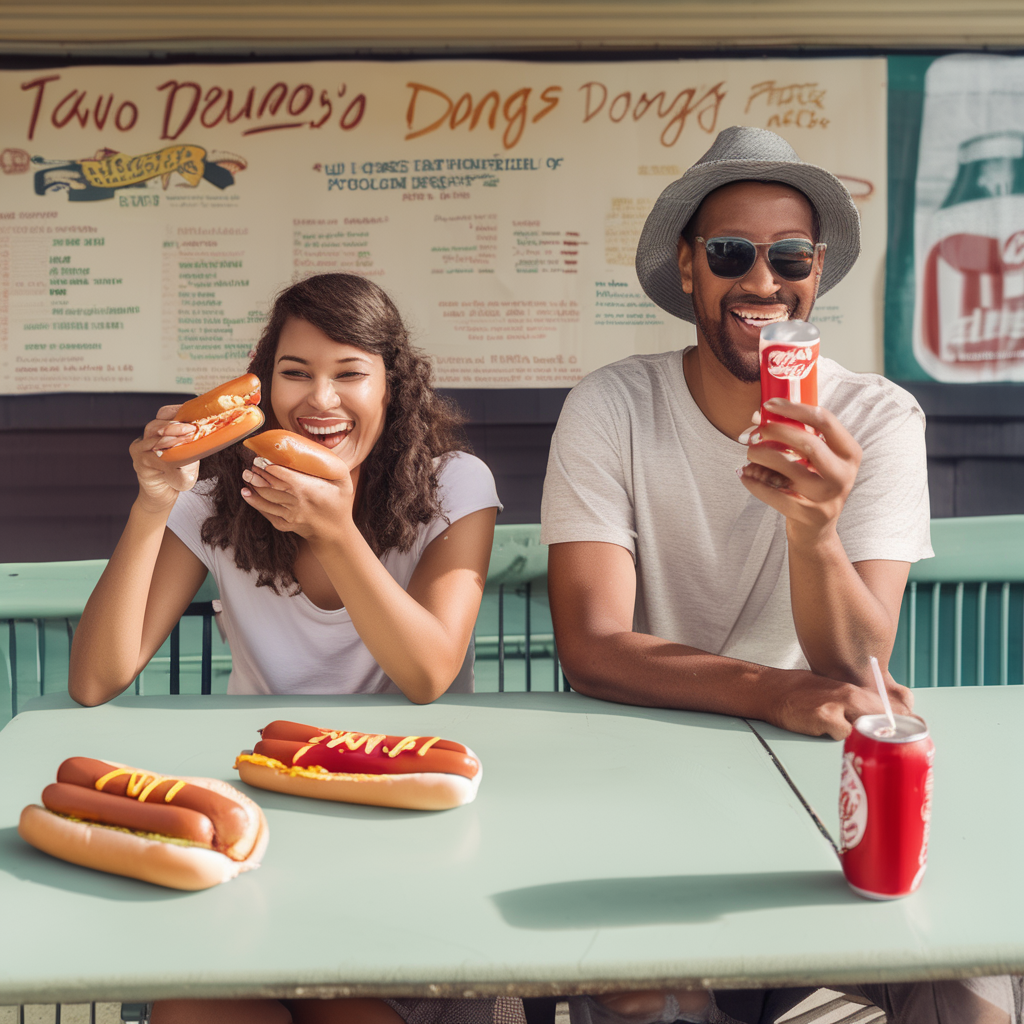

In [6]:
out.images[0]

In [7]:
# Model and tokenizer names
model_name = "google/gemma-7b-it" #"mistralai/Mistral-7B-Instruct-v0.1" #"google/gemma-7b-it" #"mistralai/Mistral-7B-Instruct-v0.1"

# Load the model and tokenizer
model = AutoModelForCausalLM.from_pretrained(model_name).eval().to(device)
tokenizer = AutoTokenizer.from_pretrained(model_name)

`config.hidden_act` is ignored, you should use `config.hidden_activation` instead.
Gemma's activation function will be set to `gelu_pytorch_tanh`. Please, use
`config.hidden_activation` if you want to override this behaviour.
See https://github.com/huggingface/transformers/pull/29402 for more details.
Loading checkpoint shards:  50%|█████     | 2/4 [00:01<00:01,  1.36it/s]

Loading checkpoint shards: 100%|██████████| 4/4 [00:02<00:00,  1.45it/s]


In [8]:
model_params = {
    "max_new_tokens": 200,
}

In [9]:
results = []
for prompt in prompts:
    result = spot_objects(tokenizer, model, prompt, **model_params)
    results.append(result)

In [10]:
results

[{'objects': [('people', [None, None]),
   ('hot dogs', [None]),
   ('soda pop', [None])],
  'bg_prompt': 'A realistic image',
  'neg_prompt': ''},
 {'objects': [('people', ['two']),
   ('umbrella', [None]),
   ('street', [None]),
   ('benches', [None]),
   ('motorcycle', [None])],
  'bg_prompt': 'A realistic image',
  'neg_prompt': ''},
 {'objects': [('woman', ['blue top']),
   ('surfboards', [None]),
   ('street', [None])],
  'bg_prompt': 'A street',
  'neg_prompt': ''},
 {'objects': [('woman', ['surfer']),
   ('wave', ['crashing']),
   ('ocean', [None])],
  'bg_prompt': 'The ocean',
  'neg_prompt': ''},
 {'objects': [('man', [None]), ('surfboard', [None]), ('beach', [None])],
  'bg_prompt': 'A beach',
  'neg_prompt': ''}]

In [11]:
detector = OWLViTv2Detector(device)

In [18]:
results_detection = detector(results[0]["objects"], out.images[0], device, 0.5, 0.3, 0.4)

In [19]:
from PIL import ImageDraw, ImageFont
width, height = out.images[0].size

img = out.images[0].copy()
draw = ImageDraw.Draw(img)
object_count = {}
for name, box_list in results_detection.items():
    for box in box_list:
        x1, y1, w, h = box
        x2 = x1 + w
        y2 = y1 + h
        x1 *= width
        x2 *= width
        y1 *= height
        y2 *= height
        draw.rectangle(((int(x1), int(y1)), (int(x2), int(y2))), outline=(255, 0, 0))
        font = ImageFont.load_default(size=20)
    
        text_size = draw.textbbox((0, 0), f"{name}, id={object_count.get(name, 0)}", font=font)
    
        text_position = (x1, max(y1 - text_size[3] - 2, 0))
        draw.text(text_position, f"{name}, id={object_count.get(name, 0)}", fill='white', font=font)
        object_count[name] = object_count.get(name, 0) + 1

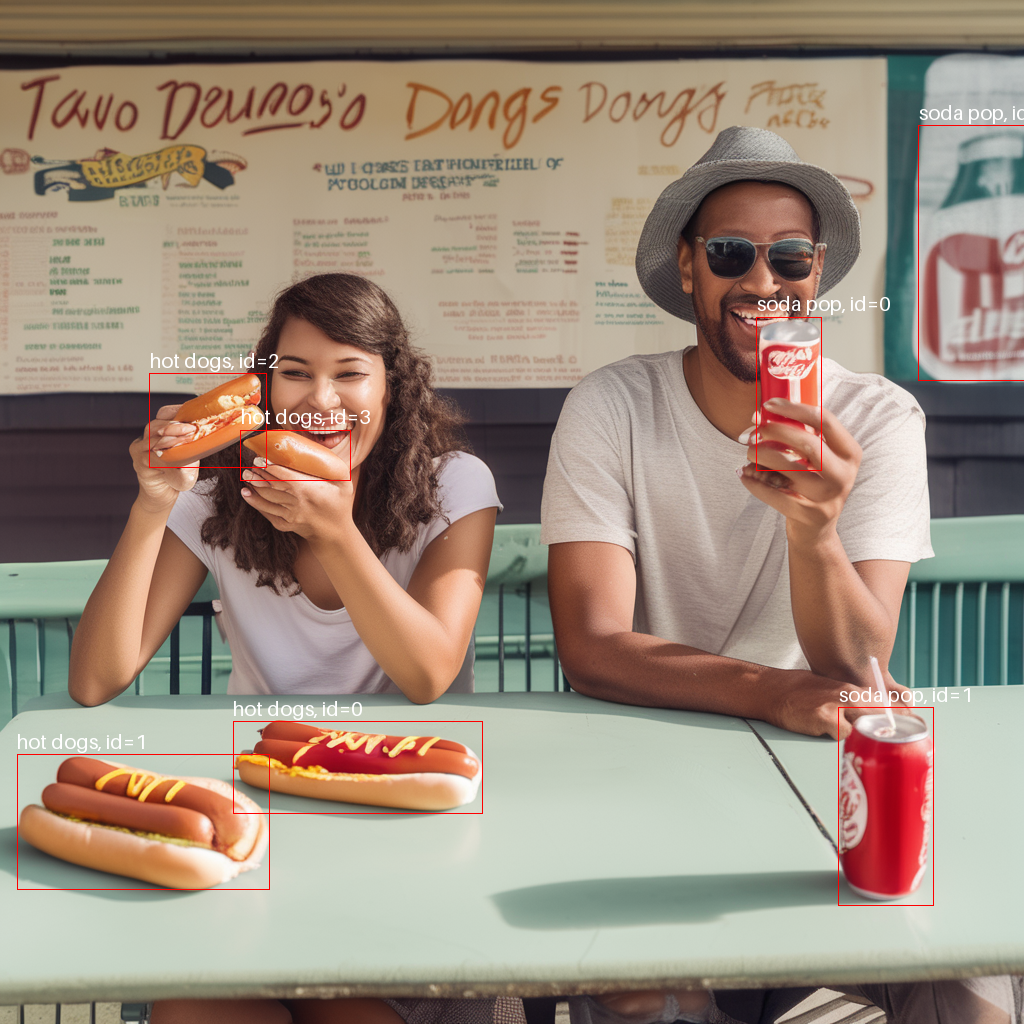

In [20]:
img